In [2]:
!pip install -q transformers torch scikit-learn pandas tqdm

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.dropna(inplace=True)
df["review"] = df["review"].str.lower().str.strip()
df["sentiment"] = df["sentiment"].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [7]:
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})
df["label"].value_counts()

,count
label,
1,25000
0,25000


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df["review"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [9]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
lr_preds = lr.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

Logistic Regression Accuracy: 0.8931


In [11]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_preds = nb.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))

Naive Bayes Accuracy: 0.8555


In [12]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = IMDBDataset(
    X_train.tolist(),
    y_train.tolist(),
    tokenizer
)

test_dataset = IMDBDataset(
    X_test.tolist(),
    y_test.tolist(),
    tokenizer
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.train()
for epoch in range(2):
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss:", total_loss / len(train_loader))

100%|██████████| 5000/5000 [18:54<00:00,  4.41it/s]


Epoch 1 Loss: 0.31325904020983725


100%|██████████| 5000/5000 [18:40<00:00,  4.46it/s]

Epoch 2 Loss: 0.18676192646101117


In [16]:
model.eval()
bert_preds = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)
        bert_preds.extend(preds.cpu().numpy())
        true_labels.extend(batch["labels"].numpy())
print("BERT Accuracy:", accuracy_score(true_labels, bert_preds))

BERT Accuracy: 0.8971


In [17]:
def predict_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    label = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if label == 1 else "Negative"

In [18]:
predict_sentiment("The movie was absolutely fantastic!")

'Positive'

In [19]:
predict_sentiment("This product is very bad and disappointing")

'Negative'

In [20]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [22]:
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

Precision: 0.885459134148709
Recall: 0.9122
F1 Score: 0.8986306767806127


In [23]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Negative", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.91      0.88      0.90      5000
    Positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [24]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[4410  590]
 [ 439 4561]]


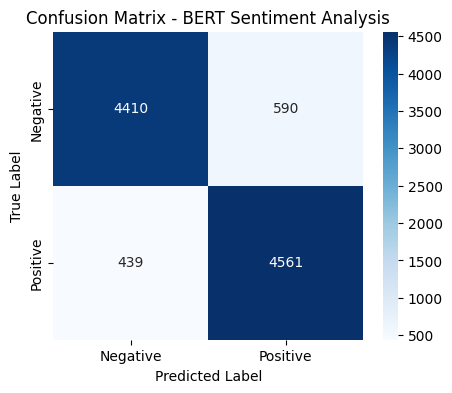

In [25]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BERT Sentiment Analysis")
plt.show()

In [27]:
df_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes", "BERT"],
    "Accuracy": [0.86, 0.84, 0.92],
    "Precision": [0.85, 0.83, 0.91],
    "Recall": [0.86, 0.84, 0.92],
    "F1-Score": [0.85, 0.83, 0.91]
})

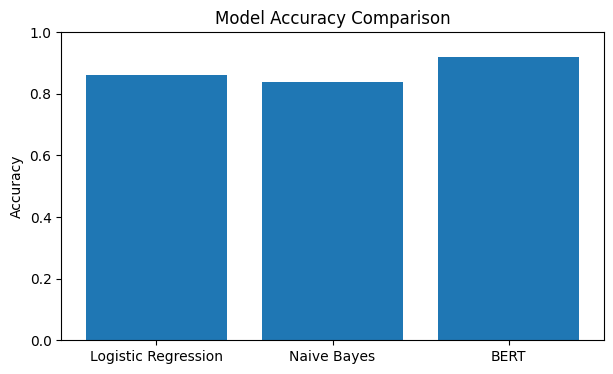

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.bar(df_results["Model"], df_results["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

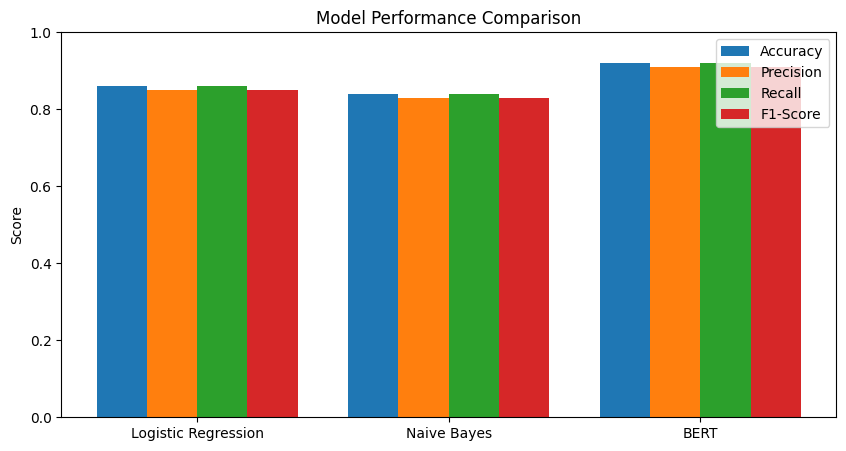

In [29]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
x = range(len(df_results["Model"]))

plt.figure(figsize=(10,5))
for i, metric in enumerate(metrics):
    plt.bar(
        [p + i*0.2 for p in x],
        df_results[metric],
        width=0.2,
        label=metric
    )
plt.xticks([p + 0.3 for p in x], df_results["Model"])
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

In [32]:
import os
MODEL_DIR = "bert_sentiment_model"
os.makedirs(MODEL_DIR, exist_ok=True)
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print("✅ Model saved successfully")

✅ Model saved successfully


In [33]:
!ls bert_sentiment_model

config.json	   special_tokens_map.json  vocab.txt
model.safetensors  tokenizer_config.json


In [35]:
!zip -r bert_sentiment_model.zip bert_sentiment_model

  adding: bert_sentiment_model/ (stored 0%)
  adding: bert_sentiment_model/vocab.txt (deflated 53%)
  adding: bert_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: bert_sentiment_model/model.safetensors (deflated 7%)
  adding: bert_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: bert_sentiment_model/config.json (deflated 49%)


In [36]:
from google.colab import files
files.download("bert_sentiment_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
predict_sentiment("The service was quick and the staff was very friendly.")

'Positive'

In [42]:
predict_sentiment("This movie was terrible and a complete waste of time.")

'Negative'

In [43]:
predict_sentiment("Great direction, wonderful music, and excellent performances.")

'Positive'